# EECS289 Final Project: Explainable NLP for Multiclass Review Rating Prediction
Team members: Tian Herng Tan (tth@berkeley.edu), Yilin Wang (yilinw25@berkeley.edu), Stephen Tao (stephen_tao@berkeley.edu)


This notebook trains an explainable multiclass classifier (1–5 stars) on the
Amazon Fine Food Reviews dataset using TF-IDF + Logistic Regression and
interpretable numeric features (user/product behavior, sentiment, etc.).

## **1. Download dataset from [Kaggle](https://www.kaggle.com/api/v1/datasets/download/snap/amazon-fine-food-reviews)**

In [ ]:
# 1. Download dataset from Kaggle (only if the zip file is missing)

import os
from pathlib import Path

DATA_DIR = Path("./")
ZIP_PATH = DATA_DIR / "amazon-fine-food-reviews.zip"
CSV_PATH = DATA_DIR / "Reviews.csv"

if not ZIP_PATH.exists():
    print("Downloading Amazon Fine Food Reviews dataset from Kaggle...")
    # This endpoint uses Kaggle API. Make sure your Kaggle token is set up in Colab.
    !curl -L -o ./amazon-fine-food-reviews.zip https://www.kaggle.com/api/v1/datasets/download/snap/amazon-fine-food-reviews
else:
    print("Zip file already exists, skipping download.")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  242M  100  242M    0     0   145M      0  0:00:01  0:00:01 --:--:--  192M


## **2. Extract zip file**

In [ ]:
# 2. Extract zip file (only if Reviews.csv does not exist yet)

import zipfile

if not CSV_PATH.exists():
    print("Extracting amazon-fine-food-reviews.zip ...")
    with zipfile.ZipFile(ZIP_PATH, "r") as zip_ref:
        zip_ref.extractall("./")
    print("Extraction completed.")
else:
    print("Reviews.csv already exists, skipping extraction.")

Extracting amazon-fine-food-reviews.zip ...
Extraction completed.


##**3. Install packages, imports, and global config**

In [ ]:
# 3. Imports and environment setup

# Install NLTK for sentiment analysis
!pip -q install nltk

import json
import os
import time
import math
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from scipy.stats import loguniform

import nltk
nltk.download("vader_lexicon")
from nltk.sentiment import SentimentIntensityAnalyzer

# Global sentiment analyzer (VADER)
sia = SentimentIntensityAnalyzer()

# Reproducibility
def set_seed(seed: int = 42) -> None:
    """Set random seeds for reproducible results."""
    random.seed(seed)
    np.random.seed(seed)

set_seed(42)

# Optional: nicer plots
plt.style.use("default")
plt.rcParams["figure.figsize"] = (6, 4)

print("Setup complete.")

Setup complete.


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


##**4. Load data and basic inspection**

Raw data shape: (568454, 10)

First 5 rows:


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...



Columns:
['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text']


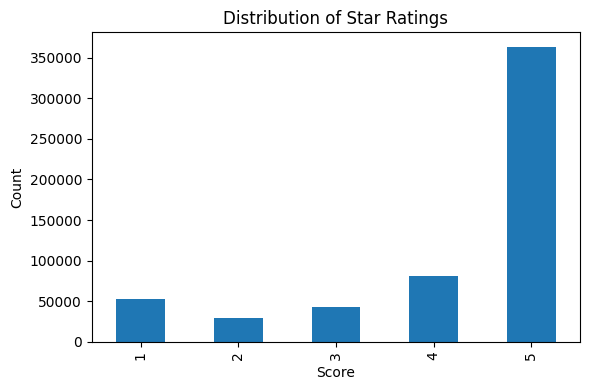

In [ ]:
# 4. Load raw reviews data and inspect basic structure

df = pd.read_csv(CSV_PATH)

print("Raw data shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

print("\nColumns:")
print(df.columns.tolist())

# Plot score distribution to see label imbalance
ax = df["Score"].value_counts().sort_index().plot(kind="bar")
ax.set_xlabel("Score")
ax.set_ylabel("Count")
ax.set_title("Distribution of Star Ratings")
plt.tight_layout()
plt.show()

##**5. Select useful columns and clean the data**

In [ ]:
# 5. Select relevant columns and perform basic cleaning

# Keep only columns needed for this project
cols_to_keep = [
    "Id",
    "ProductId",
    "UserId",
    "ProfileName",
    "HelpfulnessNumerator",
    "HelpfulnessDenominator",
    "Score",
    "Time",
    "Summary",
    "Text",
]

print("Original shape:", df.shape)
print("Selecting relevant columns:", cols_to_keep)

df = df[cols_to_keep].copy()

# Keep valid scores (1–5) and non-empty review text
df = df[df["Score"].between(1, 5)]
df = df.dropna(subset=["Text"])

# Ensure correct types
df["Score"] = df["Score"].astype(int)
df["Summary"] = df["Summary"].fillna("")

# Combine summary + full text into a single field for NLP
df["text_full"] = (df["Summary"].astype(str) + " " + df["Text"].astype(str)).str.strip()

# Convert Unix timestamp to datetime
df["Time"] = pd.to_datetime(df["Time"], unit="s", errors="coerce")

print("After cleaning shape:", df.shape)
display(df[["Score", "Summary", "Text", "text_full", "Time"]].head(3))

Original shape: (568454, 10)
Selecting relevant columns: ['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text']
After cleaning shape: (568454, 11)


,Score,Summary,Text,text_full,Time
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,Good Quality Dog Food I have bought several of...,2011-04-27
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised Product arrived labeled as J...,2012-09-07
2,4,"""Delight"" says it all",This is a confection that has been around a fe...,"""Delight"" says it all This is a confection tha...",2008-08-18


## **6. Baseline text-only model (no extra features)**

In [ ]:
# 6. Baseline model: text-only (no numeric features yet)

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Use the combined text_full (summary + text) as input
X_text = df["text_full"].values
y = df["Score"].astype(int).values

# Train–test split (stratified by score to preserve class distribution)
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text,
    y,
    test_size=0.20,
    stratify=y,
    random_state=42,
)

print("Train size:", len(X_train_text), " | Test size:", len(X_test_text))

# TF-IDF vectorizer on raw text
tfidf_baseline = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=200_000,
    min_df=2,
    max_df=0.98,
    stop_words="english",
    lowercase=True,
)

X_train_tfidf = tfidf_baseline.fit_transform(X_train_text)
X_test_tfidf = tfidf_baseline.transform(X_test_text)

# Logistic Regression classifier
logreg_baseline = LogisticRegression(
    solver="saga",
    max_iter=1000,
    n_jobs=-1,
    class_weight="balanced",
    multi_class="multinomial",
)

logreg_baseline.fit(X_train_tfidf, y_train)

# Evaluation
y_pred_baseline = logreg_baseline.predict(X_test_tfidf)
acc_baseline = accuracy_score(y_test, y_pred_baseline)
macro_f1_baseline = f1_score(y_test, y_pred_baseline, average="macro")

print(f"Baseline — Accuracy: {acc_baseline:.4f}")
print(f"Baseline — Macro-F1: {macro_f1_baseline:.4f}")

cm = confusion_matrix(y_test, y_pred_baseline, labels=[1, 2, 3, 4, 5])
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{i}" for i in [1, 2, 3, 4, 5]],
    columns=[f"pred_{i}" for i in [1, 2, 3, 4, 5]],
)
print("\nConfusion Matrix (rows=true, cols=pred):")
display(cm_df)

print("\nClassification report (baseline text-only):")
print(classification_report(y_test, y_pred_baseline, digits=3))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy:   0.7136
Macro F1:   0.5961

Confusion Matrix (rows=true, cols=pred):
        pred_1  pred_2  pred_3  pred_4  pred_5
true_1    8003    1276     712     124     211
true_2    1135    3304    1078     190     148
true_3     715    1216    5313     832     409
true_4     552     825    2590    9105    3051
true_5    2199    2032    4232    9036   55403


## **7. Feature engineering (review-level numeric features)**

In [ ]:
# 7. Review-level numeric features: helpfulness, length, sentiment, time

def safe_ratio(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    """
    Compute a / b with protection against division by zero.
    Returns 0.0 when b <= 0.
    """
    return np.where(b > 0, a / np.clip(b, 1, None), 0.0)

# Helpfulness ratio: how many found the review helpful / total votes
df["help_ratio"] = safe_ratio(
    df["HelpfulnessNumerator"].fillna(0).astype(float),
    df["HelpfulnessDenominator"].fillna(0).astype(float),
)

# Length-based features
df["word_len"] = df["text_full"].str.split().apply(len).astype(int)
df["char_len"] = df["text_full"].str.len().astype(int)

# Sentiment (compound score in [-1, 1])
df["sentiment"] = df["text_full"].map(
    lambda t: sia.polarity_scores(str(t))["compound"]
).astype(float)

# Recency feature: days since earliest review
min_time = df["Time"].min()
df["review_age_days"] = (df["Time"] - min_time).dt.days.fillna(0).astype(float)

print("Review-level features added:")
display(df[["Score", "help_ratio", "word_len", "char_len", "sentiment", "review_age_days"]].head())

print("\nSummary statistics (review-level features):")
display(df[["Score", "help_ratio", "word_len", "char_len", "sentiment", "review_age_days"]].describe())

Review-level features added:


,Score,help_ratio,word_len,char_len,sentiment,review_age_days
0,5,1.0,52,285,0.9583,4219.0
1,1,0.0,34,208,-0.5664,4718.0
2,4,1.0,98,531,0.8265,3237.0
3,2,1.0,43,234,0.0000,4266.0
4,5,0.0,29,152,0.9661,4762.0



Summary statistics (review-level features):


,Score,help_ratio,word_len,char_len,sentiment,review_age_days
count,568454.000000,568454.000000,568454.000000,568454.000000,568454.000000,568454.000000
mean,4.183199,0.407862,84.377125,460.667780,0.690862,4130.969964
std,1.310436,0.462068,80.253687,449.843623,0.474480,556.056856
min,1.000000,0.000000,4.000000,23.000000,-0.999400,0.000000
25%,4.000000,0.000000,37.000000,200.000000,0.698800,3842.000000
50%,5.000000,0.000000,60.000000,325.000000,0.902000,4303.000000
75%,5.000000,1.000000,102.000000,554.000000,0.958300,4553.000000
max,5.000000,3.000000,3451.000000,21535.000000,0.999900,4767.000000


## **8. Feature engineering (user & product aggregates)**

In [ ]:
# 8. User-level and product-level aggregate features

# Group by user
user_grp = df.groupby("UserId")

df["user_review_count"] = user_grp["Id"].transform("count")
df["user_avg_rating"]   = user_grp["Score"].transform("mean")
df["user_rating_std"]   = user_grp["Score"].transform("std").fillna(0.0)
df["user_help_avg"]     = user_grp["help_ratio"].transform("mean")

# Group by product
prod_grp = df.groupby("ProductId")

df["prod_review_count"] = prod_grp["Id"].transform("count")
df["prod_avg_rating"]   = prod_grp["Score"].transform("mean")
df["prod_rating_std"]   = prod_grp["Score"].transform("std").fillna(0.0)
df["prod_help_avg"]     = prod_grp["help_ratio"].transform("mean")
df["prod_wordlen_avg"]  = prod_grp["word_len"].transform("mean")

# Final numeric feature list
numeric_features = [
    "help_ratio",
    "word_len",
    "char_len",
    "sentiment",
    "review_age_days",
    "user_review_count",
    "user_avg_rating",
    "user_rating_std",
    "user_help_avg",
    "prod_review_count",
    "prod_avg_rating",
    "prod_rating_std",
    "prod_help_avg",
    "prod_wordlen_avg",
]

print("Numeric features:", len(numeric_features))
display(df[numeric_features].head(3))

print("\nDataFrame shape after feature engineering:", df.shape)
print("First 20 columns:")
print(df.columns.tolist()[:20])

Numeric features: 14


,help_ratio,word_len,char_len,sentiment,review_age_days,user_review_count,user_avg_rating,user_rating_std,user_help_avg,prod_review_count,prod_avg_rating,prod_rating_std,prod_help_avg,prod_wordlen_avg
0,1.0,52,285,0.9583,4219.0,1,5.000000,0.00000,1.000000,1,5.0,0.0,1.0,52.0
1,0.0,34,208,-0.5664,4718.0,1,1.000000,0.00000,0.000000,1,1.0,0.0,0.0,34.0
2,1.0,98,531,0.8265,3237.0,3,4.333333,0.57735,0.333333,1,4.0,0.0,1.0,98.0



DataFrame shape after feature engineering: (568454, 25)
First 20 columns:
['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text', 'text_full', 'help_ratio', 'word_len', 'char_len', 'sentiment', 'review_age_days', 'user_review_count', 'user_avg_rating', 'user_rating_std', 'user_help_avg']


## **9. Full Model (Text + Numeric Features) — Baseline & Early Evaluation**

In [ ]:
## 9. Full Model (Text + Numeric Features) — Baseline & Early Evaluation

# Build modeling dataset: target + text + numeric features
data = df[["Score", "text_full"] + numeric_features].copy()

# Features (X) and target (y)
X = data.drop(columns=["Score"])
y = data["Score"].astype(int)

# Train–test split (stratified by rating)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    stratify=y,
    random_state=42,
)

print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)

# Column-wise preprocessing:
# - TF-IDF on 'text_full'
# - StandardScaler on numeric_features
text_col = "text_full"

preprocess = ColumnTransformer(
    transformers=[
        (
            "tfidf",
            TfidfVectorizer(
                ngram_range=(1, 2),
                max_features=200_000,
                min_df=2,
                max_df=0.98,
                stop_words="english",
                lowercase=True,
            ),
            text_col,
        ),
        (
            "num",
            StandardScaler(with_mean=False),
            numeric_features,
        ),
    ],
    remainder="drop",
    sparse_threshold=0.3,  # keep sparse representation when possible
)

# Logistic Regression classifier (multiclass, class-balanced)
clf = LogisticRegression(
    solver="saga",
    max_iter=1000,
    n_jobs=-1,
    class_weight="balanced",
    multi_class="multinomial",
    C=1.0,  # baseline regularization strength
)

# Full pipeline: preprocessing + classifier
pipe = Pipeline(
    steps=[
        ("prep", preprocess),
        ("clf", clf),
    ]
)

# Fit on training data
pipe.fit(X_train, y_train)

# Hold-out evaluation on test data
y_pred = pipe.predict(X_test)
acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

print(f"Baseline — Accuracy: {acc:.4f} | Macro-F1: {macro_f1:.4f}")

Train shape: (454763, 15) | Test shape: (113691, 15)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Baseline — Accuracy: 0.8515 | Macro-F1: 0.7715


In [ ]:
## 9.1 Cross-Validation (Early Evaluation)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scoring = {"acc": "accuracy", "f1": "f1_macro"}

cv_res = cross_validate(
    pipe,
    data.drop(columns=["Score"]),
    data["Score"].astype(int),
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False,
)

print(
    "CV Accuracy:",
    cv_res["test_acc"].mean().round(4),
    "+/-",
    cv_res["test_acc"].std().round(4),
)
print(
    "CV Macro-F1:",
    cv_res["test_f1"].mean().round(4),
    "+/-",
    cv_res["test_f1"].std().round(4),
)

CV Accuracy: 0.8493 +/- 0.0035
CV Macro-F1: 0.7677 +/- 0.0028


## **10. Build small stratified subset + fast search for C**

In [ ]:
## 10. Hyperparameter Tuning (C) – Quick Experiment

# 10.1 Create a ~100k stratified subset from X_train/y_train for faster search

SEARCH_SIZE = 100_000

# Attach labels to the training features
tmp = X_train.copy()
tmp["Score"] = y_train.values

# Sample roughly equal amount per class (SEARCH_SIZE // 5 per rating)
sub = (
    tmp.groupby("Score", group_keys=False)
       .apply(lambda t: t.sample(min(len(t), SEARCH_SIZE // 5), random_state=42))
       .sample(frac=1.0, random_state=42)  # shuffle
)

X_search = sub.drop(columns=["Score"])
y_search = sub["Score"].astype(int)

print("Search subset shape:", X_search.shape)
print("Class distribution in search subset:")
display(y_search.value_counts().sort_index())

from tempfile import mkdtemp
from joblib import Memory
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from scipy.stats import loguniform

# 10.2 Define a faster pipeline for tuning (simpler TF-IDF to speed up CV)

cachedir = mkdtemp()  # cache preprocessed matrices between CV folds

preprocess_fast = ColumnTransformer(
    transformers=[
        (
            "tfidf",
            TfidfVectorizer(
                ngram_range=(1, 1),     # unigrams only during search
                max_features=100_000,   # smaller vocab
                min_df=5,
                max_df=0.95,
                stop_words="english",
                lowercase=True,
            ),
            "text_full",
        ),
        (
            "num",
            StandardScaler(with_mean=False),
            numeric_features,
        ),
    ],
    remainder="drop",
)

clf_fast = LogisticRegression(
    solver="saga",
    max_iter=500,
    n_jobs=-1,
    class_weight="balanced",
    multi_class="multinomial",
)

pipe_fast = Pipeline(
    steps=[("prep", preprocess_fast), ("clf", clf_fast)],
    memory=Memory(location=cachedir, verbose=0),
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# We only tune C (regularization strength) using a log-uniform prior
param_dist_fast = {"clf__C": loguniform(1e-2, 10)}

search_fast = RandomizedSearchCV(
    estimator=pipe_fast,
    param_distributions=param_dist_fast,
    n_iter=8,                 # small, fast search
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1,
)

search_fast.fit(X_search, y_search)

print("Fast search — best CV Macro-F1:", round(search_fast.best_score_, 4))
print("Fast search — best params:", search_fast.best_params_)

best_C = search_fast.best_params_["clf__C"]
print("Selected best_C:", best_C)

Search subset shape: (100000, 15)
Class distribution in search subset:


/tmp/ipython-input-2889302785.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda t: t.sample(min(len(t), SEARCH_SIZE // 5), random_state=42))


,count
Score,
1,20000
2,20000
3,20000
4,20000
5,20000


Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fast search — best CV Macro-F1: 0.7469
Fast search — best params: {'clf__C': np.float64(0.13292918943162169)}
Selected best_C: 0.13292918943162169


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Final (tuned C) — Accuracy:  0.8438
Final (tuned C) — Macro-F1:  0.7616


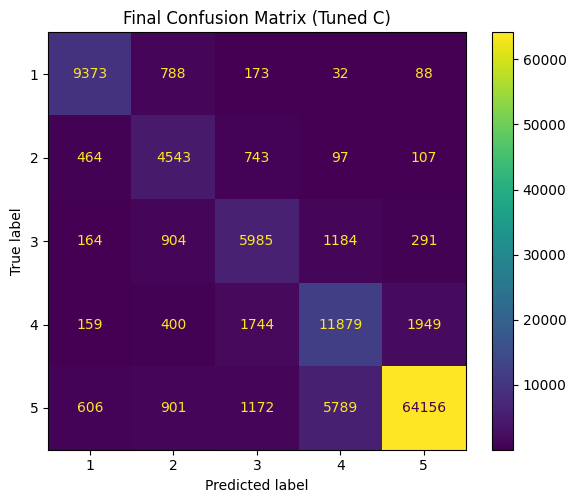


Classification report (tuned C):
              precision    recall  f1-score   support

           1      0.871     0.897     0.883     10454
           2      0.603     0.763     0.674      5954
           3      0.610     0.702     0.652      8528
           4      0.626     0.736     0.677     16131
           5      0.963     0.883     0.922     72624

    accuracy                          0.844    113691
   macro avg      0.734     0.796     0.762    113691
weighted avg      0.862     0.844     0.850    113691



In [ ]:
# 10.3 Refit full model (text + numeric) on X_train using best_C

preprocess_final = ColumnTransformer(
    transformers=[
        (
            "tfidf",
            TfidfVectorizer(
                ngram_range=(1, 2),      # restore unigrams + bigrams
                max_features=200_000,    # larger vocab
                min_df=2,
                max_df=0.98,
                stop_words="english",
                lowercase=True,
            ),
            "text_full",
        ),
        (
            "num",
            StandardScaler(with_mean=False),
            numeric_features,
        ),
    ],
    remainder="drop",
)

clf_final = LogisticRegression(
    solver="saga",
    max_iter=1000,
    n_jobs=-1,
    class_weight="balanced",
    multi_class="multinomial",
    C=best_C,  # tuned regularization
)

pipe_final = Pipeline(
    steps=[
        ("prep", preprocess_final),
        ("clf", clf_final),
    ]
)

pipe_final.fit(X_train, y_train)

# Evaluate tuned model on the same test split
y_pred_final = pipe_final.predict(X_test)

acc_final = accuracy_score(y_test, y_pred_final)
macro_f1_final = f1_score(y_test, y_pred_final, average="macro")

print(f"Final (tuned C) — Accuracy:  {acc_final:.4f}")
print(f"Final (tuned C) — Macro-F1:  {macro_f1_final:.4f}")

# Optional: confusion matrix + classification report
fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_final,
    labels=[1, 2, 3, 4, 5],
    ax=ax,
)
plt.title("Final Confusion Matrix (Tuned C)")
plt.tight_layout()
plt.show()

print("\nClassification report (tuned C):")
print(classification_report(y_test, y_pred_final, digits=3))

##**11. Global explainability using Logistic Regression coefficients**

In [ ]:
## 11. Global Explainability – Coefficients for Text & Numeric Features

# Extract fitted components from the pipeline
prep = pipe.named_steps["prep"]
clf = pipe.named_steps["clf"]

# 1) Get feature names from TF-IDF and numeric parts
tfidf = prep.named_transformers_["tfidf"]
num_scaler = prep.named_transformers_["num"]

tfidf_feature_names = tfidf.get_feature_names_out()
num_feature_names = np.array(numeric_features)

# ColumnTransformer stacks tfidf features first, then numeric features
all_feature_names = np.concatenate([tfidf_feature_names, num_feature_names])

print("Total features after preprocessing:", len(all_feature_names))

# 2) Get logistic regression coefficients
# Shape: (n_classes, n_features) with classes = [1,2,3,4,5]
coef = clf.coef_   # numpy array

classes = clf.classes_
print("Classes:", classes)

Total features after preprocessing: 200014
Classes: [1 2 3 4 5]


In [ ]:
# Top words and numeric features for 1 star vs 5 stars
def show_top_features_for_class(class_idx, top_k=15):
    """Print top positive and negative features for a given class index."""
    class_label = classes[class_idx]
    w = coef[class_idx]

    # sort coefficients
    top_pos_idx = np.argsort(w)[-top_k:][::-1]
    top_neg_idx = np.argsort(w)[:top_k]

    print(f"\n=== Class {class_label} — Top + features ===")
    for i in top_pos_idx:
        print(f"{all_feature_names[i]:25s}  {w[i]:.4f}")

    print(f"\n=== Class {class_label} — Top - features ===")
    for i in top_neg_idx:
        print(f"{all_feature_names[i]:25s}  {w[i]:.4f}")

# Example: inspect 1-star and 5-star classes
idx_1 = np.where(classes == 1)[0][0]
idx_5 = np.where(classes == 5)[0][0]

show_top_features_for_class(idx_1, top_k=15)
show_top_features_for_class(idx_5, top_k=15)


=== Class 1 — Top + features ===
worst                      6.6420
awful                      5.9233
horrible                   5.6479
yuck                       5.4551
terrible                   5.2803
threw                      5.1704
money                      5.1186
disgusting                 4.5149
away                       4.4262
sorry                      3.8371
nasty                      3.6724
disappointed               3.6714
waste                      3.6644
stale                      3.5935
like                       3.3227

=== Class 1 — Top - features ===
great                      -6.8555
stars                      -5.0198
user_avg_rating            -4.4113
tasty                      -4.3884
good                       -4.2091
bit                        -4.0130
nice                       -3.9901
best                       -3.6152
little                     -3.2237
delicious                  -3.0917
decent                     -2.8937
gave stars                 -2.7418
qu

##**12. Partial dependence plots for numeric features**

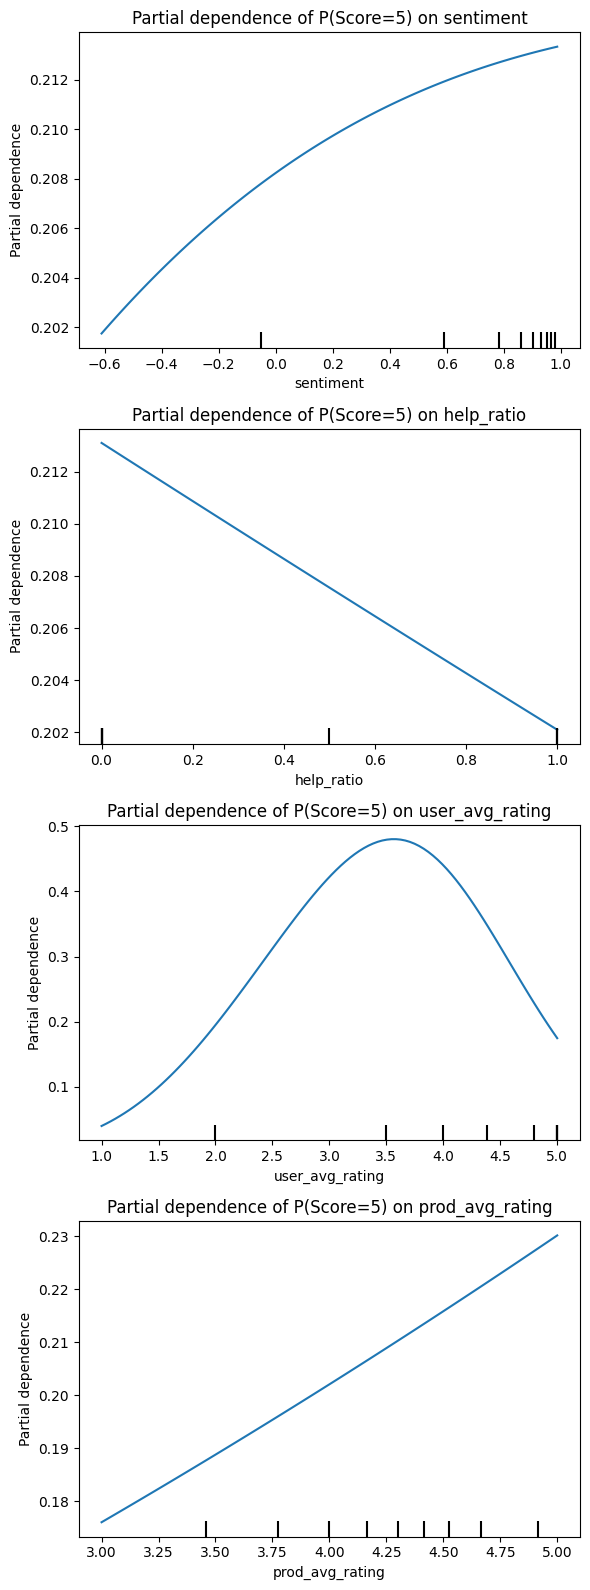

In [ ]:
## 12. Partial Dependence Plots – Numeric Features

from sklearn.inspection import PartialDependenceDisplay

# Use a smaller sample for speed
X_pd = X_train.sample(20000, random_state=42)  # X has 'text_full' + numeric_features

features_to_plot = ["sentiment", "help_ratio", "user_avg_rating", "prod_avg_rating"]

fig, ax = plt.subplots(len(features_to_plot), 1, figsize=(6, 4 * len(features_to_plot)))

for i, feat in enumerate(features_to_plot):
    PartialDependenceDisplay.from_estimator(
        pipe,
        X_pd,
        [feat],            # use original column name
        target=4,          # e.g., class index for 5-star (classes[target] == 5)
        ax=ax[i],
    )
    ax[i].set_title(f"Partial dependence of P(Score=5) on {feat}")

plt.tight_layout()
plt.show()

##**13. Local Explainability – Per-review Explanation Helper**

In [ ]:
## 13. Local Explainability – Inspect Single Reviews

import numpy as np

prep = pipe.named_steps["prep"]
clf  = pipe.named_steps["clf"]

# Get feature names from the ColumnTransformer
tfidf = prep.named_transformers_["tfidf"]
num_scaler = prep.named_transformers_["num"]

tfidf_feature_names = tfidf.get_feature_names_out()
num_feature_names   = np.array(numeric_features)

# In our ColumnTransformer, TF-IDF features come first, then numeric ones
all_feature_names = np.concatenate([tfidf_feature_names, num_feature_names])

classes = clf.classes_
print("Classes:", classes)


def explain_review(test_index: int, top_k_words: int = 10, top_k_num: int = 5):
    """
    Explain a single review from X_test/y_test.

    - Shows text, true label, predicted label and class probabilities.
    - Lists top contributing words for the predicted class.
    - Lists contributions from numeric features (sentiment, user_avg_rating, etc.).
    """
    # 1) Get the original row and label
    row_X = X_test.iloc[[test_index]]   # keep as DataFrame
    true_y = y_test.iloc[test_index]

    print("=" * 80)
    print(f"Review index in test set: {test_index}")
    print(f"True Score: {true_y}")

    text = row_X["text_full"].values[0]
    print("\n--- Review text (truncated) ---")
    print(text[:800] + ("..." if len(text) > 800 else ""))

    # 2) Transform with the pipeline's preprocessor
    X_trans = prep.transform(row_X)        # shape (1, n_features), sparse
    proba   = clf.predict_proba(X_trans)[0]
    pred    = clf.predict(X_trans)[0]

    print("\nPredicted Score:", pred)
    print("Class probabilities:")
    for c, p in zip(classes, proba):
        print(f"  P(Score={c}) = {p:.3f}")

    # 3) Get contributions for the predicted class
    class_idx = np.where(classes == pred)[0][0]
    w = clf.coef_[class_idx]  # (n_features,)

    # contributions = x_j * w_j  (for this class)
    # For a single row, converting to dense is OK
    x_dense = X_trans.toarray()[0]
    contrib = x_dense * w   # (n_features,)

    # Split into text vs numeric parts
    n_tfidf = len(tfidf_feature_names)
    contrib_text = contrib[:n_tfidf]
    contrib_num  = contrib[n_tfidf:]
    assert len(contrib_num) == len(num_feature_names)

    # 4) Top contributing words (positive and negative)
    print("\n=== Top contributing words for predicted class ===")
    # only consider non-zero tf-idf entries for readability
    nonzero_idx = np.where(contrib_text != 0)[0]

    if len(nonzero_idx) == 0:
        print("No non-zero word contributions found.")
    else:
        nz_contrib = contrib_text[nonzero_idx]
        nz_words   = tfidf_feature_names[nonzero_idx]

        top_pos_idx = np.argsort(nz_contrib)[-top_k_words:][::-1]
        top_neg_idx = np.argsort(nz_contrib)[:top_k_words]

        print("\nTop positive word contributions:")
        for i in top_pos_idx:
            print(f"{nz_words[i]:25s}  contribution={nz_contrib[i]: .4f}")

        print("\nTop negative word contributions:")
        for i in top_neg_idx:
            print(f"{nz_words[i]:25s}  contribution={nz_contrib[i]: .4f}")

    # 5) Numeric feature contributions
    print("\n=== Numeric feature contributions ===")
    # sort by absolute contribution magnitude
    order_num = np.argsort(np.abs(contrib_num))[::-1][:top_k_num]

    for i in order_num:
        fname = num_feature_names[i]
        val   = row_X[fname].values[0]
        cval  = contrib_num[i]
        print(f"{fname:20s} value={val:8.4f}  contribution={cval: .4f}")

Classes: [1 2 3 4 5]


In [ ]:
# Example: explain the first test review
explain_review(0)

Review index in test set: 0
True Score: 5

--- Review text (truncated) ---
beautiful but smaller than I thought. My Dad loved this gift, I loved how it was wrapped and the appearance, although I must say that I was expecting something a bit larger than what this turned out to be.

Predicted Score: 5
Class probabilities:
  P(Score=1) = 0.000
  P(Score=2) = 0.001
  P(Score=3) = 0.091
  P(Score=4) = 0.403
  P(Score=5) = 0.505

=== Top contributing words for predicted class ===

Top positive word contributions:
loved                      contribution= 0.1693
wrapped                    contribution= 0.0797
beautiful                  contribution= 0.0712
dad loved                  contribution= 0.0209
loved gift                 contribution= 0.0174
bit larger                 contribution= 0.0125
larger                     contribution= 0.0091
expecting bit              contribution=-0.0029
smaller thought            contribution=-0.0177
say                        contribution=-0.0502

Top ne

In [ ]:
# Find one misclassified sample and explain it
y_pred_all = pipe.predict(X_test)
mis_idx = np.where(y_pred_all != y_test.values)[0]

print("Number of misclassified examples:", len(mis_idx))
if len(mis_idx) > 0:
    explain_review(int(mis_idx[0]))

Number of misclassified examples: 16886
Review index in test set: 4
True Score: 4

--- Review text (truncated) ---
dark roast very dark roast, strong coffee, very good.  Sorry, the rest of message is fill in to make it to the new rule by amazon of at least 20 words.

Predicted Score: 5
Class probabilities:
  P(Score=1) = 0.000
  P(Score=2) = 0.004
  P(Score=3) = 0.130
  P(Score=4) = 0.426
  P(Score=5) = 0.440

=== Top contributing words for predicted class ===

Top positive word contributions:
new                        contribution= 0.0728
rule                       contribution= 0.0507
roast strong               contribution= 0.0431
dark                       contribution= 0.0260
strong coffee              contribution= 0.0150
words                      contribution= 0.0054
make                       contribution= 0.0029
amazon                     contribution=-0.0002
coffee good                contribution=-0.0066
20 words                   contribution=-0.0369

Top negative word co

## **14. Linear SVM (LinearSVC)**

In [ ]:
from sklearn.svm import LinearSVC

clf_svm = LinearSVC(
    C=1.0,
    class_weight="balanced",
    max_iter=5000
)

pipe_svm = Pipeline([
    ("prep", preprocess),   # same ColumnTransformer as before
    ("clf", clf_svm),
])

pipe_svm.fit(X_train, y_train)

y_pred_svm = pipe_svm.predict(X_test)
print("LinearSVC — Accuracy:",
      round(accuracy_score(y_test, y_pred_svm),4),
      "| Macro-F1:",
      round(f1_score(y_test, y_pred_svm, average="macro"),4))

LinearSVC — Accuracy: 0.8693 | Macro-F1: 0.7509


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold

clf_svm = LinearSVC(
    class_weight="balanced",
    max_iter=5000,
)

pipe_svm = Pipeline([
    ("prep", preprocess),   # same ColumnTransformer as before
    ("clf", clf_svm),
])

param_grid_svm = {
    "clf__C": [0.25, 0.5, 1.0, 2.0]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_svm = GridSearchCV(
    estimator=pipe_svm,
    param_grid=param_grid_svm,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=1,
)

grid_svm.fit(X_train, y_train)

print("Best C for SVM:", grid_svm.best_params_)
print("Best CV macro-F1:", round(grid_svm.best_score_, 4))

best_svm = grid_svm.best_estimator_

y_pred_svm = best_svm.predict(X_test)
print("LinearSVC (tuned) — Accuracy:",
      round(accuracy_score(y_test, y_pred_svm),4),
      "| Macro-F1:",
      round(f1_score(y_test, y_pred_svm, average="macro"),4))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best C for SVM: {'clf__C': 0.25}
Best CV macro-F1: 0.7435
LinearSVC (tuned) — Accuracy: 0.8733 | Macro-F1: 0.7573


##**15. SGDClassifier (linear model trained with SGD)**

In [ ]:
from sklearn.linear_model import SGDClassifier

clf_sgd = SGDClassifier(
    loss="log_loss",         # logistic regression
    class_weight="balanced",
    max_iter=20,
    n_jobs=-1,
    random_state=42
)

pipe_sgd = Pipeline([
    ("prep", preprocess),
    ("clf", clf_sgd),
])

pipe_sgd.fit(X_train, y_train)
y_pred_sgd = pipe_sgd.predict(X_test)

print("SGD (log_loss) — Accuracy:",
      round(accuracy_score(y_test, y_pred_sgd),4),
      "| Macro-F1:",
      round(f1_score(y_test, y_pred_sgd, average="macro"),4))

SGD (log_loss) — Accuracy: 0.7889 | Macro-F1: 0.5988


##**16. Model Comparison table**

In [ ]:
## 16. Model Comparison Summary

models = {}

# 1) Logistic Regression (main explainable model)
y_pred_lr = pipe.predict(X_test)
models["Logistic Regression"] = {
    "Accuracy": accuracy_score(y_test, y_pred_lr),
    "Macro-F1": f1_score(y_test, y_pred_lr, average="macro"),
}

# 2) LinearSVC (tuned)
y_pred_svm = best_svm.predict(X_test)
models["LinearSVC (C=0.25)"] = {
    "Accuracy": accuracy_score(y_test, y_pred_svm),
    "Macro-F1": f1_score(y_test, y_pred_svm, average="macro"),
}

# 3) SGDClassifier (log_loss)
y_pred_sgd = pipe_sgd.predict(X_test)
models["SGD (log_loss)"] = {
    "Accuracy": accuracy_score(y_test, y_pred_sgd),
    "Macro-F1": f1_score(y_test, y_pred_sgd, average="macro"),
}

results_df = (
    pd.DataFrame(models)
      .T
      .applymap(lambda x: round(x, 4))
      .sort_values("Macro-F1", ascending=False)
)

results_df

/tmp/ipython-input-2326743524.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(lambda x: round(x, 4))


,Accuracy,Macro-F1
Logistic Regression,0.8515,0.7715
LinearSVC (C=0.25),0.8733,0.7573
SGD (log_loss),0.7889,0.5988


##**18. Decide and “freeze” the main model**

In [ ]:
## 18. Choose final main model (for explainability)

final_model = pipe      # Logistic Regression pipeline (text + numeric)

# Sanity check
y_pred_final = final_model.predict(X_test)
print("Final model — Accuracy:",
      round(accuracy_score(y_test, y_pred_final),4),
      "| Macro-F1:",
      round(f1_score(y_test, y_pred_final, average="macro"),4))

Final model — Accuracy: 0.8515 | Macro-F1: 0.7715


##**19.Save the models for reproducibility**

In [ ]:
## 19. Save trained models to disk

import joblib

joblib.dump(final_model, "final_logreg_pipeline.joblib")
joblib.dump(best_svm, "linearsvc_pipeline_C0_25.joblib")

print("Models saved.")

Models saved.
